In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{ widht:90% !important; }<\style>"))
display(HTML("<style>.container{ font-size:18px !important; }<\style>"))

C:\Users\JOHANA\AppData\Local\Temp\ipykernel_8652\2404769486.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#Libraries Python
import spiceypy as spy 
import numpy as np 
import datetime
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import urllib.request
import statsmodels.api as sm
from scipy import stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from sbpy.data import Ephem
from astropy.time import Time 
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
from astroquery.jplsbdb import SBDB 
from poliastro.bodies import *
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D
from poliastro.frames import Planes

In [3]:
#Constants and parameters
au = 149597870.693 # [km], Link: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/de-403-masses.tpc
mu = 132712440023.31 # [km^3*s^-2] G*M_sun Solar gravitational parameter
ae = 23 + 26/60 + 12/3600 # Angle of obliquity of the elliptic from sexagesimal->decimal
deg = np.pi/180 # Parameters that will be used frequently in the codes
rad = 1/deg 

url = 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls'
filename = 'naif0012.tls'
urllib.request.urlretrieve(url, filename)

N = 265
'''N is the number of intervals in which the orbital period of a small
body to be analyzed will be separated'''

'N is the number of intervals in which the orbital period of a small\nbody to be analyzed will be separated'

In [4]:
#Array filled with data of the first date of the three to use
time_arange1 = np.full((N,1), '2015-06', dtype = 'datetime64[D]')

#Array with data of successive dates from the first date identified in the previous line.
time_arange2 = np.arange('2015-06', '2017-06', dtype='datetime64[D]')
time_arange3 = np.arange('2015-06', '2018-06', dtype='datetime64[D]')
time_arange2 = time_arange2[0:N].reshape((N,1), order='C')

print(time_arange1.shape, time_arange2.shape, time_arange3.shape)

(265, 1) (265, 1) (1096,)


In [5]:
''' His part of the code is for building a
table with dates organized in such a way that
we let's have increasing ranges of times, equally
spaced in days, starting from the first date.
So:

#Date1 #Date2 #Date3 
1      2      3
1      3      5
1      4      7
1      5      9       
1      6      11
.      .      .
.      .      .
.      .      .

'''

time_arangep = pd.DataFrame(time_arange3, columns = ['Times'])

time_arangep ['index'] = time_arangep.index

dates_index  = time_arangep[time_arangep['index'] % 2 == 0 ]

time_arangef = dates_index['Times']

time_arangef = time_arangef.to_numpy()

a = np.asarray(time_arangef).reshape((548,1))

time_arange_nd = a[0:N]

Dates_to_Gauss = np.concatenate((time_arange1, time_arange2, time_arange_nd), axis = 1)

Dates_to_Gauss = Dates_to_Gauss[1:N]

t= pd.to_datetime(Dates_to_Gauss,cache=False)

# To remove the hours and leave only year-month-day
Dates_to_Gauss = t.strftime('%Y-%m-%d')



In [6]:
#time_arangef.shape

In [7]:
# Gauss method for preliminary determination of orbits

def astronomical_time(date):
    spy.furnsh("naif0012.tls")
    tu=spy.str2et(date) 
    dt=spy.deltet(tu,"ET") 
    t=tu-dt
    return (t)


def ephemerides(epoch):
    eph = Ephem.from_mpc('5587', epochs=epoch,location='568')["RA","DEC","epoch"] 
    return(eph) 

def earth_position(P_earth):
    t = Time(P_earth)
    P=get_body_barycentric('earth',t,ephemeris='de432s')
    return P


def calculate_celestial_position(observation):
    alfa = observation["RA"]
    delta = observation["DEC"]
    return alfa,delta

def method_gauss(alfa,delta,t):
        
    #Unit vector for the first observation
    u1 = np.array([np.cos(delta[0]*deg)*np.cos(alfa[0]*deg),np.cos(delta[0]*deg)*np.sin(alfa[0]*deg),np.sin(delta[0]*deg)])
      
    #Unit vector for the second observation
    u2 = np.array([np.cos(delta[1]*deg)*np.cos(alfa[1]*deg),np.cos(delta[1]*deg)* np.sin(alfa[1]*deg),np.sin(delta[1]*deg)])
      
    #Unit vector for the third observation
    u3 = np.array([np.cos(delta[2]*deg)*np.cos(alfa[2]*deg),np.cos(delta[2]*deg)*np.sin(alfa[2]*deg),np.sin(delta[2]*deg)])
    #print("u1=",u1)
    #print ("u2=",u2)
    #print("u3=",u3)
    #print("\n")

    #Lagrangian coefficients
    r2 = 3*au #Arbitrary value
      
    f3 = 1-mu/(2*r2**3)*(t[2]-t[1])**2
    g3 = (t[2]-t[1])-mu/(6*r2**3)*(t[2]-t[1])**3
      
    f1 = 1-mu/(2*r2**3)*(t[0]-t[1])**2
    g1 = (t[0]-t[1])-mu/(6*r2**3)*(t[0]-t[1])**3
      
      
    #Constants  
    c1 = g3/(f1*g3-f3*g1)
    c3 = -g1/(f1*g3-f3*g1)
      
    #pho2 value
    rho2 = (np.dot(P2,np.cross(u1,u3))-c1*np.dot(P1,np.cross(u1,u3))-c3*np.dot(P3,np.cross(u1,u3)))/np.dot(u2,np.cross(u1,u3))
      
      
    #Loop to find the true value of r2
    r2=3*au
    for i in range(30):
        f3 = 1-mu/(2*r2**3)*(t[2]-t[1])**2
        g3 = (t[2]-t[1])-mu/(6*r2**3)*(t[2]-t[1])**3

        f1=1-mu/(2*r2**3)*(t[0]-t[1])**2
        g1=(t[0]-t[1])-mu/(6*r2**3)*(t[0]-t[1])**3

        c1 = g3/(f1*g3-f3*g1)
        c3 = -g1/(f1*g3-f3*g1)

        rho2 = (np.dot(P2,np.cross(u1,u3))-c1*np.dot(P1,np.cross(u1,u3))-c3*np.dot(P3,np.cross(u1,u3)))/np.dot(u2,np.cross(u1,u3))

        r2 = (np.linalg.norm(P2)**2+rho2**2-2*rho2*np.dot(P2,u2))**0.5
        
        
    #pho1 and pho3 values
    rho1 = (-np.dot(P2,np.cross(u2,u3))+c1*np.dot(P1,np.cross(u2,u3))+c3*np.dot(P3,np.cross(u2,u3)))/(c1*np.dot(u1,np.cross(u2,u3)))
    rho3 = (-np.dot(P2,np.cross(u2,u1))+c1*np.dot(P1,np.cross(u2,u1))+c3*np.dot(P3,np.cross(u2,u1)))/(c3*np.dot(u3,np.cross(u2,u1)))
    
    
      
    #r1 and r3 values
    r1 = np.sqrt(np.linalg.norm(P1)**2+rho1**2-2*rho1*np.dot(P1,u1))
    r3 = np.sqrt(np.linalg.norm(P3)**2+rho3**2-2*rho3*np.dot(P3,u3))
      
      
    """Vectors in their rectangular components""" 
      
    #Position vectors
    r1vec = (rho1*u1-P1)
    r2vec = (rho2*u2-P2)
    r3vec = (rho3*u3-P3)

    #Speed vector
    v2vec=(-f3*r1vec+f1*r3vec)/(f1*g3-f3*g1)
      
    #print("Geocentric state vector values",r1vec,r2vec,r3vec,v2vec)
    return(r1vec,r2vec,r3vec,v2vec)

def ecliptic_positions(ra):
    sx = ra[0]
    sy = ra[1]*np.cos(ae*deg)+ra[2]*np.sin(ae*deg) 
    sz = ra[2]*np.cos(ae*deg)-ra[1]*np.sin(ae*deg)
    return(sx,sy,sz)

def ecliptic_velocity(va):
    vx = va[0]
    vy = va[1]*np.cos(ae*deg)+va[2]*np.sin(ae*deg) 
    vz = va[2]*np.cos(ae*deg)-va[1]*np.sin(ae*deg)
    return(vx,vy,vz)
      

def orbital_elements(r1,v2):
    h = np.cross(r1,v2)

    #Node Vector    
    k = np.array([0,0,1])
    N = np.cross(k,h)

    #Eccentricity vector
    l = np.cross(v2,h)-mu*(r1/np.linalg.norm(r1))
    e = l/mu


    #Inclination
    i = np.arccos(h[2]/np.linalg.norm(h))*rad

    #Eccentricity
    ex = np.linalg.norm(e)

    
    #Node length
    if N[1]>=0:
        long_node = np.arccos(N[0]/np.linalg.norm(N))*rad 
        if long_node<0:
            long_node = long_node + 360
    else:
        long_node = 2 * np.pi-np.arccos(N[0]/np.linalg.norm(N))*rad
        if long_node<0:
            long_node = long_node + 360
        
    

    #Perihelion argument
    if e[2]>=0:
        arg_perh = np.arccos(np.dot(N,e)/(np.linalg.norm(N)*np.linalg.norm(e)))*rad
        if arg_perh<0:
            arg_perh = arg_perh + 360
    else:
        arg_perh = 2 * np.pi-np.arccos(np.dot(N,e)/(np.linalg.norm(N)*np.linalg.norm(e)))*rad
        if arg_perh<0:
            arg_perh = arg_perh + 360


    #True anomaly
    A = np.dot(e,r2)
    B = ex*np.linalg.norm(r2)
    anom_true = np.arccos(np.linalg.norm(A/B))*rad

    
    #semi-latus rectum
    q = np.linalg.norm(h**2/mu)/au
    
    #Semi-major axis
    a = q /(1-ex**2)

    return(a,i,ex,long_node,arg_perh,anom_true)

In [8]:
list_dates = []
data_orbital_elements = {
    "a":[],
    "e":[],
    "i":[],
    "long_node":[],
    "arg_perh":[],
    "anom_true":[]    
}
for i in range(len(Dates_to_Gauss)):
    
    date1 = Dates_to_Gauss[i][0]
    date2 = Dates_to_Gauss[i][1]
    date3 = Dates_to_Gauss[i][2]

    t1 = astronomical_time(date1)
    t2 = astronomical_time(date2)
    t3 = astronomical_time(date3)

    t = [t1,t2,t3]
    list_three_dates = [date1,date2,date3]
    #delta_tiempos = [t[0]-t[1],t[1]-t[2]]

    epoch1 = Time(Dates_to_Gauss[i][0], scale='utc')
    epoch2 = Time(Dates_to_Gauss[i][1], scale='utc')
    epoch3 = Time(Dates_to_Gauss[i][2], scale='utc')

    observation1 = ephemerides(epoch1)
    observation2 = ephemerides(epoch2)
    observation3 = ephemerides(epoch3)
    
    #print("ob1=",observation1)
    #print("ob2=",observation2)
    #print("ob3=",observation3)


    P_earth1 = earth_position(date1)
    P_earth2 = earth_position(date2)
    P_earth3 = earth_position(date3)

    P1 = np.array([-P_earth1.x/u.km,-P_earth1.y/u.km,-P_earth1.z/u.km])
    P2 = np.array([-P_earth2.x/u.km,-P_earth2.y/u.km,-P_earth2.z/u.km])
    P3 = np.array([-P_earth3.x/u.km,-P_earth3.y/u.km,-P_earth3.z/u.km])
    
    
    #First observation
    alfa1,delta1 = calculate_celestial_position(observation1)  
        
    #second observation
    alfa2,delta2 = calculate_celestial_position(observation2)
        
    #Third observation
    alfa3,delta3 = calculate_celestial_position(observation3)

  
    alfa = np.array([alfa1,alfa2,alfa3])
    delta = np.array([delta1,delta2,delta3])

    #To convert multilist to list
    alfa = alfa.flatten()
    delta = delta.flatten()

    
    r1vec,r2vec,r3vec,v2vec = method_gauss(alfa,delta,t)
    
    
  
    r1 = ecliptic_positions(r1vec)
    r2 = ecliptic_positions(r2vec)
    r3 = ecliptic_positions(r3vec)
    
    v2 = ecliptic_velocity(v2vec)
  
    
    a,i,ex,long_node,arg_perh,anom_true = orbital_elements(r1,v2)
    

#ADDING ORBITAL ELEMENTS TO THE DICTIONARY AND DATES
    list_dates.append(list_three_dates)
    data_orbital_elements["a"].append(a)
    data_orbital_elements["e"].append(ex)
    data_orbital_elements["i"].append(i)
    data_orbital_elements["long_node"].append(long_node)
    data_orbital_elements["arg_perh"].append(arg_perh)
    data_orbital_elements["anom_true"].append(anom_true)

    
    '''print("a=",a)
    print("i=",i)
    print("ex=",ex)
    print("long_node=",long_node)
    print("arg_perh=",arg_perh)
    print("anom_true=",anom_true)
    print("\n")''' 
    


In [9]:
Data_orbital_elements = pd.DataFrame(data_orbital_elements)
Data_orbital_elements

,a,e,i,long_node,arg_perh,anom_true
0,1.517317,0.702701,18.118454,198.796621,110.705706,14.077145
1,2.462969,0.511148,18.209524,194.986322,77.299689,49.253640
2,2.095059,0.578206,17.972924,197.292999,88.683926,36.544605
3,2.135940,0.562650,18.073099,196.573847,87.944370,37.967307
4,2.067132,0.570436,18.109524,196.571320,90.613407,35.539198
...,...,...,...,...,...,...
259,-2.202776,5.004290,163.501716,347.656185,5.904581,22.112323
260,-2.286602,4.980473,163.306050,347.252797,4.774830,20.078231
261,-2.357620,4.965918,163.128322,346.892259,3.629522,17.989810
262,-2.414324,4.960833,162.968529,346.573912,2.461217,15.836195


In [10]:
a = Data_orbital_elements[Data_orbital_elements["a"]>0]["a"] #Semi major axis
e = Data_orbital_elements[(Data_orbital_elements["e"]>0)&(Data_orbital_elements["e"]<1)]["e"] #Eccentricity
i = Data_orbital_elements["i"] #Inclination
long_node = Data_orbital_elements["long_node"] #Ascending node longitude
arg_perh = Data_orbital_elements["arg_perh"] #Perihelion argument
anom_true = Data_orbital_elements["anom_true"] #True anomaly
times = np.arange(0,N-1)

In [11]:
#Table of asteroids referenced in the JPL Horizons NASA
table_JPL = pd.read_csv('sbdb_query_results.csv')

"""Filtering the theoretical orbital elements of the chosen asteroid"""
asteroid_data = table_JPL[table_JPL['spkid'] == 2005587]
a_asteroid = np.mean(asteroid_data['a']) #Theoretical Semi major axis
e_asteroid = np.mean(asteroid_data['e']) #Theoretical eccentricity
i_asteroid = np.mean(asteroid_data['i']) #Theoretical inclination
long_node_asteroid = np.mean(asteroid_data['om']) #Theoretical ascending node longitude
arg_perh_asteroid = np.mean(asteroid_data['w']) #Theoretical perihelion argument
anom_true_asteroid = np.mean(asteroid_data['ma']) #Theoretical true anomaly


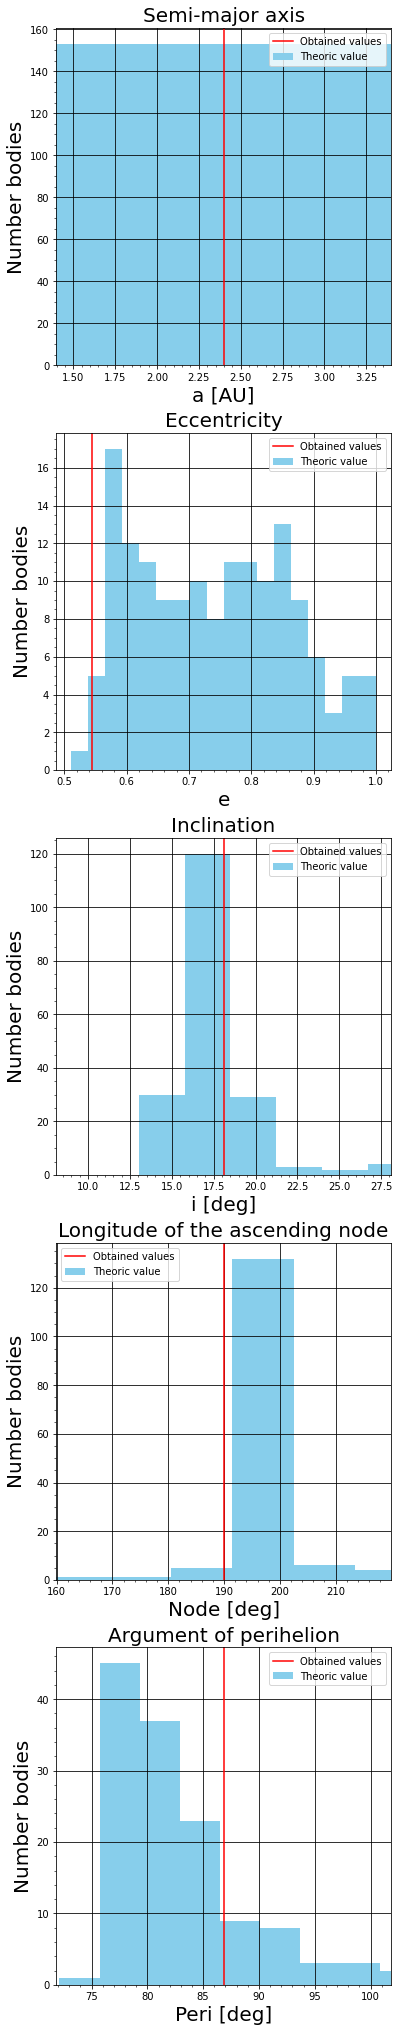

In [12]:
fag,ax = plt.subplots(5,1, figsize=(6,36)) 

ax[0].hist(a,bins=500,color="skyblue");
ax[0].set_xlim(a_asteroid-1, a_asteroid+1)
#ax.set_ylim(0, 2.6)
ax[0].axvline(a_asteroid, color='red',markersize=50)
ax[0].set_xlabel('a [AU]', size=20)
ax[0].set_ylabel('Number bodies', size=20)
ax[0].set_title('Semi-major axis', size = 20)
ax[0].grid(color='black')
ax[0].legend(["Obtained values","Theoric value"],loc='best')
ax[0].minorticks_on()



ax[1].hist(e,bins=18,color="skyblue");
ax[1].axvline(e_asteroid, color='red',markersize=50) 
ax[1].set_xlabel('e', size=20)
ax[1].set_ylabel('Number bodies', size=20)
ax[1].set_title('Eccentricity', size = 20)
ax[1].grid(color='black')
#ex.axhline(y=e_asteroid, color='red',markersize=50)
ax[1].legend(["Obtained values","Theoric value"],loc='best')
ax[1].minorticks_on()



ax[2].set_ylabel('Number bodies', size=20)
ax[2].hist(i,bins=60,color="skyblue");
ax[2].set_xlim(i_asteroid-10, i_asteroid+10)
ax[2].set_xlabel('i [deg]', size=20)
ax[2].set_title('Inclination', size = 20)
ax[2].axvline(i_asteroid, color='red',markersize=50) 
ax[2].grid(color='black')
ax[2].legend(["Obtained values","Theoric value"],loc='best')
ax[2].minorticks_on()



ax[3].hist(long_node,bins=30,color="skyblue");
ax[3].set_xlim(long_node_asteroid-30, long_node_asteroid+30)
ax[3].axvline(long_node_asteroid, color='red',markersize=50) 
ax[3].set_xlabel('Node [deg]', size=20)
ax[3].set_ylabel('Number bodies', size=20)
ax[3].set_title('Longitude of the ascending node', size = 20)
ax[3].grid(color='black')
ax[3].legend(["Obtained values","Theoric value"],loc='best')
ax[3].minorticks_on()



ax[4].hist(arg_perh,bins=100,color="skyblue");
ax[4].set_xlim(arg_perh_asteroid-15, arg_perh_asteroid+15)
ax[4].axvline(arg_perh_asteroid, color='red',markersize=50) 
#hx.axhline(y= arg_perh_asteroid, xmin=0, xmax=50, color='blue')
ax[4].set_xlabel('Peri [deg]', size=20)
ax[4].set_ylabel('Number bodies', size=20)
ax[4].set_title('Argument of perihelion', size = 20)
ax[4].grid(color='black')
ax[4].legend(["Obtained values","Theoric value"],loc='best')
ax[4].minorticks_on()

In [13]:
#Delta of theoretical value and value obtained for each orbital element
Data_orbital_elements['delta_a'] = np.abs(Data_orbital_elements['a'] - a_asteroid) #semi-major axis
Data_orbital_elements['delta_e'] = np.abs(Data_orbital_elements['e'] - e_asteroid) #eccentricity
Data_orbital_elements['delta_i'] = np.abs(Data_orbital_elements['i'] - i_asteroid) #inclination
Data_orbital_elements['delta_node'] = np.abs(Data_orbital_elements['long_node'] - long_node_asteroid) #ascending node longitude 
Data_orbital_elements['delta_perh'] = np.abs(Data_orbital_elements['arg_perh'] - arg_perh_asteroid) #perihelion argument


#Index of the minimum delta value of each orbital element
Index_a = np.argmin(Data_orbital_elements['delta_a']) 
Index_e = np.argmin(Data_orbital_elements['delta_e'])
Index_i = np.argmin(Data_orbital_elements['delta_i'])
Index_node = np.argmin(Data_orbital_elements['delta_node'])
Index_perh = np.argmin(Data_orbital_elements['delta_perh'])


In [14]:
# Ordering of 5 orbital elements with the smallest delta respect to them theoretical values.

#semi-major axis
sort_a = Data_orbital_elements.sort_values('a')
df_sort_a  = sort_a.head()
arr_sort_a = np.array(df_sort_a)


#eccentricity
sort_e = Data_orbital_elements.sort_values('e')
df_sort_e  = sort_e.head()
arr_sort_e = np.array(df_sort_e)


#inclination
sort_i = Data_orbital_elements.sort_values('i')
df_sort_i  = sort_i.head()
arr_sort_i = np.array(df_sort_i)


#ascending node longitude
sort_long_node = Data_orbital_elements.sort_values('long_node')
df_sort_long_node  = sort_long_node.head()
arr_sort_long_node = np.array(df_sort_long_node)


#perihelion argument
sort_arg_perh = Data_orbital_elements.sort_values('arg_perh')
df_sort_arg_perh  = sort_arg_perh.head()
arr_sort_arg_perh = np.array(df_sort_arg_perh)

In [15]:
#This part of code show the orbital elements with smallest delta respect to them theoretical values

a_ref = np.array(Data_orbital_elements[np.argmin(Data_orbital_elements['delta_a']):
                                       np.argmin(Data_orbital_elements['delta_a'])+1])

e_ref = np.array(Data_orbital_elements[np.argmin(Data_orbital_elements['delta_e']):
                                       np.argmin(Data_orbital_elements['delta_e'])+1])

i_ref = np.array(Data_orbital_elements[np.argmin(Data_orbital_elements['delta_i']):
                                       np.argmin(Data_orbital_elements['delta_i'])+1])

long_node_ref = np.array(Data_orbital_elements[np.argmin(Data_orbital_elements['delta_node']):
                                               np.argmin(Data_orbital_elements['delta_node'])+1])

arg_perh_ref = np.array(Data_orbital_elements[np.argmin(Data_orbital_elements['delta_perh']):
                                              np.argmin(Data_orbital_elements['delta_perh'])+1])


In [16]:
theoretical_table = pd.DataFrame(asteroid_data)
filtered_values = pd.DataFrame(np.concatenate([a_ref, e_ref, i_ref, long_node_ref, arg_perh_ref]),
                           columns = ['a','e','i','long_node','arg_perh','mean_anomaly','da','de','di',
                                      'd(long_node)','d(arg_perh)'])
                                                                                          

In [17]:
"""Table with the orbital data obtained and filtered, as well as their 
corresponding observation dates used for their calculation and the data number 
to which the orbital element corresponds"""

Dates_obs = pd.DataFrame([list_dates[Index_a],list_dates[Index_e],list_dates[Index_i],
                          list_dates[Index_node],list_dates[Index_perh]],columns = ['Date1','Date2','Date3'])

Data_number = pd.DataFrame([Index_a,Index_e,Index_i,Index_node,Index_perh],columns = ['Data number'])

filtered_values_table = pd.concat([Data_number,Dates_obs, filtered_values.iloc[:,0:6]], axis=1)

filtered_values_table

,Data number,Date1,Date2,Date3,a,e,i,long_node,arg_perh,mean_anomaly
0,31,2015-06-01,2015-07-03,2015-08-04,2.394536,0.608890,18.099448,196.250934,80.910634,49.617518
1,5,2015-06-01,2015-06-07,2015-06-13,2.195332,0.552834,18.125233,196.124161,86.197259,40.320783
2,11,2015-06-01,2015-06-13,2015-06-25,2.254547,0.566671,18.090575,196.279431,84.052623,43.240579
3,129,2015-06-01,2015-10-09,2016-02-16,1.327719,0.905298,22.240937,189.933062,121.735491,33.989083
4,106,2015-06-01,2015-09-16,2016-01-01,2.972164,0.828538,18.570347,195.383772,86.742964,59.028102


In [18]:
#Eliminating negative values of the semi-axis
filtered_values_table = filtered_values_table[filtered_values_table['a']>0]
filtered_values_table = filtered_values_table.reset_index(drop=True) #Resetting dataframe index
filtered_values_table

,Data number,Date1,Date2,Date3,a,e,i,long_node,arg_perh,mean_anomaly
0,31,2015-06-01,2015-07-03,2015-08-04,2.394536,0.608890,18.099448,196.250934,80.910634,49.617518
1,5,2015-06-01,2015-06-07,2015-06-13,2.195332,0.552834,18.125233,196.124161,86.197259,40.320783
2,11,2015-06-01,2015-06-13,2015-06-25,2.254547,0.566671,18.090575,196.279431,84.052623,43.240579
3,129,2015-06-01,2015-10-09,2016-02-16,1.327719,0.905298,22.240937,189.933062,121.735491,33.989083
4,106,2015-06-01,2015-09-16,2016-01-01,2.972164,0.828538,18.570347,195.383772,86.742964,59.028102


In [19]:
# Applying logarithm to the orbital elements to be able to graph
theoretical_matrix_a = np.log10(np.full((len(filtered_values_table)), theoretical_table["a"]))
theoretical_matrix_e = np.log10(np.full((len(filtered_values_table)), theoretical_table["e"]))
theoretical_matrix_i = np.log10(np.full((len(filtered_values_table)), theoretical_table["i"]))
theoretical_matrix_long_node = np.log10(np.full((len(filtered_values_table)), theoretical_table["om"]))
theoretical_matrix_arg_perh = np.log10(np.full((len(filtered_values_table)), theoretical_table["w"]))

Filtered_values_table = np.log10(np.abs(filtered_values_table.iloc[:,4:9]))
Filtered_values_table

,a,e,i,long_node,arg_perh
0,0.379221,-0.215461,1.257665,2.292812,1.908006
1,0.341500,-0.257405,1.258284,2.292531,1.935493
2,0.353059,-0.246669,1.257452,2.292875,1.924551
3,0.123106,-0.043208,1.347153,2.278601,2.085417
4,0.473073,-0.081688,1.268820,2.290888,1.938234


In [20]:
#Calculating the errors of each orbital element set
error_e = np.array(np.abs((Filtered_values_table['e'] - theoretical_matrix_e)/theoretical_matrix_e))
error_a = np.array(np.abs((Filtered_values_table['a'] - theoretical_matrix_a)/theoretical_matrix_a))
error_i = np.array(np.abs((Filtered_values_table['i'] - theoretical_matrix_i)/theoretical_matrix_i))
error_node = np.array(np.abs((Filtered_values_table['long_node'] - theoretical_matrix_long_node)/theoretical_matrix_long_node))
error_arg = np.array(np.abs((Filtered_values_table['arg_perh'] - theoretical_matrix_arg_perh)/theoretical_matrix_arg_perh))

In [21]:
# Computing the linear least squares regression for the orbital element dataset.
y = np.array([theoretical_matrix_a, theoretical_matrix_e, theoretical_matrix_i,
     theoretical_matrix_long_node, theoretical_matrix_arg_perh])

y = y.reshape(((len(theoretical_matrix_a)*5)), order='C')    

x = np.array([Filtered_values_table['a'],Filtered_values_table['e'],Filtered_values_table['i'], 
    Filtered_values_table['long_node'], Filtered_values_table['arg_perh']])

x = x.reshape(((len(theoretical_matrix_a)*5)), order='C')  

slope,intercept, r_value, p_value, std_err = stats.linregress(x,y)

print(slope, intercept, r_value, p_value, std_err)

def lineal_function(x):
    return slope*x + intercept 

Y = lineal_function(x)


1.0067262669425567 -0.027770737211396224 0.9959382061319892 1.4788697639240461e-25 0.018977874686251915


Text(0.5, 1.0, 'Lineal squares minimum aproximation')

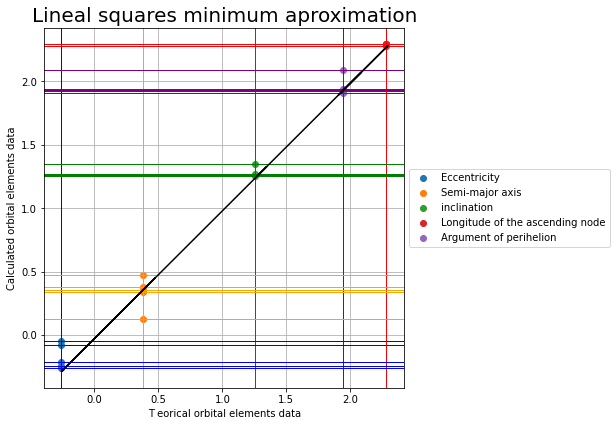

In [22]:
#linear least squares regression plot

fig = plt.figure(figsize=(7,5))
ejes = fig.add_axes([0,0,1,1])

ejes.scatter(theoretical_matrix_e, Filtered_values_table['e'])
ejes.scatter(theoretical_matrix_a, Filtered_values_table['a'])
ejes.scatter(theoretical_matrix_i, Filtered_values_table['i'])
ejes.scatter(theoretical_matrix_long_node, Filtered_values_table['long_node'])
ejes.scatter(theoretical_matrix_arg_perh, Filtered_values_table['arg_perh'])

ejes.axvline(theoretical_matrix_e[0], color = 'blue', label = 'theoretical a', lw = 1)
ejes.axvline(theoretical_matrix_a[0], color = 'orange', label = 'theoretical a', lw = 1)
ejes.axvline(theoretical_matrix_i[0], color = 'green', label = 'theoretical a', lw = 1)
ejes.axvline(theoretical_matrix_long_node[0], color = 'red', label = 'theoretical a', lw = 1)
ejes.axvline(theoretical_matrix_arg_perh[0], color = 'purple', label = 'theoretical a', lw = 1)

for i in range (len(Filtered_values_table)):
    ejes.axhline(Filtered_values_table['e'][i], color = 'blue', label = 'exp a', lw = 1)
    ejes.axhline(Filtered_values_table['a'][i], color = 'orange', label = 'exp e', lw = 1)
    ejes.axhline(Filtered_values_table['i'][i], color = 'green', label = 'exp i', lw = 1)
    ejes.axhline(Filtered_values_table['long_node'][i], color = 'red', label = 'exp node', lw = 1)
    ejes.axhline(Filtered_values_table['arg_perh'][i], color = 'purple', label = 'exp peri', lw = 1)




ejes.legend(["Eccentricity" , "Semi-major axis","inclination",
             "Longitude of the ascending node","Argument of perihelion"],loc='center left', bbox_to_anchor=(1, 0.5))


plt.grid()
fig.set_size_inches(5, 5)
ejes.plot(x,Y, color = 'black')
ejes.set_xlabel('T eorical orbital elements data', size = 10)
ejes.set_ylabel('Calculated orbital elements data', size = 10)
ejes.set_title('Lineal squares minimum aproximation', size = 20)

Text(0.5, 1.0, 'Error bar')

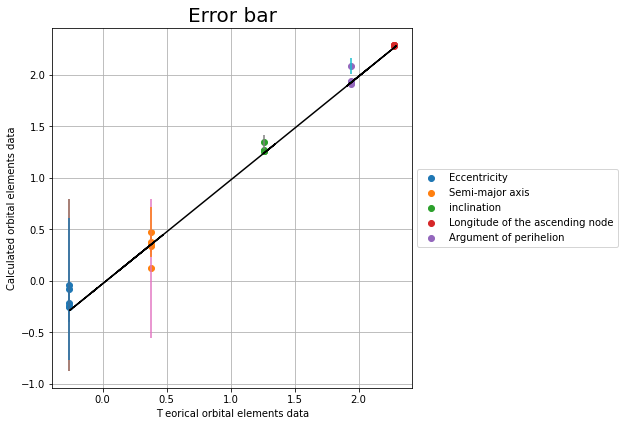

In [23]:
fig = plt.figure(figsize=(7,5))
ejes = fig.add_axes([0,0,1,1])
ecolor= ['black', 'red', 'blue', 'white']  


ejes.scatter(theoretical_matrix_e, Filtered_values_table['e'])
ejes.scatter(theoretical_matrix_a, Filtered_values_table['a'])
ejes.scatter(theoretical_matrix_i, Filtered_values_table['i'])
ejes.scatter(theoretical_matrix_long_node, Filtered_values_table['long_node'])
ejes.scatter(theoretical_matrix_arg_perh, Filtered_values_table['arg_perh'])


for i in range (len(Filtered_values_table)):
    ejes.errorbar(theoretical_matrix_e[i],Filtered_values_table['e'][i],yerr = error_e[i])
    ejes.errorbar(theoretical_matrix_a[i],Filtered_values_table['a'][i],yerr = error_a[i])
    ejes.errorbar(theoretical_matrix_i[i],Filtered_values_table['i'][i],yerr = error_i[i])
    ejes.errorbar(theoretical_matrix_long_node[i],Filtered_values_table['long_node'][i],yerr = error_node[i])
    ejes.errorbar(theoretical_matrix_arg_perh[i],Filtered_values_table['arg_perh'][i],yerr = error_arg[i])



ejes.legend(["Eccentricity" , "Semi-major axis","inclination",
             "Longitude of the ascending node","Argument of perihelion"],loc='center left', bbox_to_anchor=(1, 0.5))


plt.grid()
fig.set_size_inches(5, 5)
ejes.plot(x,Y, color = 'black')
ejes.set_xlabel('T eorical orbital elements data', size = 10)
ejes.set_ylabel('Calculated orbital elements data', size = 10)
ejes.set_title('Error bar', size = 20)

In [24]:
#Generate artificial data (2 regressors + constant)
#Fit regression model
results = sm.OLS(y, x).fit()

#Inspect the results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              6762.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                    6.18e-31
Time:                        12:25:56   Log-Likelihood:                          25.520
No. Observations:                  25   AIC:                                     -49.04
Df Residuals:                      24   BIC:                                     -47.82
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [60]:
"""Plotting the orbits closest to the theoretical one, 
for each orbit graph, .sample is used, a poliastro function that allows 
knowing the points that make up the orbit"""
n = 100; #number of orbit points
list_determined_orbit = []
list_points_determinated_orbit = []

epoch = Time("2022-08-09", scale="tdb")
epoch1 = Time(f'{list_dates[filtered_values_table["Data number"][0]][2]}', scale="tdb")
epoch2 = Time(f'{list_dates[filtered_values_table["Data number"][1]][2]}', scale="tdb")
epoch3 = Time(f'{list_dates[filtered_values_table["Data number"][2]][2]}', scale="tdb")
epoch4 = Time(f'{list_dates[filtered_values_table["Data number"][3]][2]}', scale="tdb")


orbit_JPL = Orbit.from_classical(attractor= Sun, epoch=epoch, a=asteroid_data.iloc[0,1]*u.au,
                               ecc=asteroid_data.iloc[0,2]*u.one,
                               inc=asteroid_data.iloc[0,3]*u.deg,
                               raan=asteroid_data.iloc[0,4]*u.deg,
                               argp=asteroid_data.iloc[0,5]*u.deg, 
                               nu=asteroid_data.iloc[0,6]*u.deg)

theorical_orbit = orbit_JPL.sample(values=n)/au

for i in range (len(filtered_values_table)):
   
    determined_orbit = Orbit.from_classical(attractor= Sun, epoch=epoch1, a = filtered_values_table["a"][i]*u.au, 
                                 ecc = filtered_values_table["e"][i]*u.one, inc = filtered_values_table["i"][i]*u.deg, 
                                 raan = filtered_values_table["long_node"][i]*u.deg, 
                                 argp = filtered_values_table["arg_perh"][i]*u.deg, 
                                 nu = filtered_values_table["mean_anomaly"][i]*u.deg)

    points_determinated_orbit = determined_orbit.sample(values=n)/au
    
    
    list_determined_orbit.append(determined_orbit)
    list_points_determinated_orbit.append(points_determinated_orbit)



C:\Users\JOHANA\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\decorators.py:304: UserWarning: Wrapping true anomaly to -π <= nu < π
  return_ = wrapped_function(*func_args, **func_kwargs)


In [73]:
theoretical_magnitudes = []
magnitudes_obtained = []

"""x_theoretical = []
x_obtained = []

y_theoretical = []
y_obtained = []

z_theoretical = []
z_obtained = []"""

for k in range (len(theorical_orbit)):
    mag_or = theorical_orbit[k].x/u.km,theorical_orbit[k].y/u.km,theorical_orbit[k].z/u.km
    theoretical_magnitudes.append(np.linalg.norm(mag_or))
    for j in range (len(list_points_determinated_orbit)):
        mag_or1 = list_points_determinated_orbit[j][k].x/u.km,list_points_determinated_orbit[j][k].y/u.km,list_points_determinated_orbit[j][k].z/u.km
        magnitudes_obtained.append(np.linalg.norm(mag_or1))


    """x_theoretical.append(mag_or[0]) 
        x_obtained.append(mag_or1[0])      

        y_theoretical.append(mag_or[1]) 
        y_obtained.append(mag_or1[1])  

        z_theoretical.append(mag_or[2]) 
        z_obtained.append(mag_or1[2])"""
        
magnitudes_obtained = [magnitudes_obtained[i:i+n] for i in range(0, len(magnitudes_obtained), n)]

In [84]:
#CALCULO DE ERROR
error = []
for h in range (len(magnitudes_obtained)):
    def mse(magnitudes_obtained, theoretical_magnitudes): 
        #axis_major, NA = np.array(axis_major), np.array(NA)
        result = np.square(np.subtract(magnitudes_obtained[h],theoretical_magnitudes)).mean()
        result = np.sqrt(result)
        return result

    result = mse(magnitudes_obtained[h], theoretical_magnitudes)
    result = result/np.sqrt(len(magnitudes_obtained[h]))
    error.append(result*100)
#97.66277064016862/np.sqrt(430),resultado

In [99]:
table_error = pd.DataFrame(error, columns = {'error %'})
table_error

,error %
0,16.032832
1,9.235333
2,14.442821
3,9.475298
4,13.758568


In [102]:
table_error.min()

error %    9.235333
dtype: float64